# Compare to PE Network

## Preliminaries

In [1]:
# Imports
import numpy as np
import matplotlib.pylab as plt
import torch
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

## Dataset

In [3]:
# Warp
def RandomSample():
    theta = ( np.random.rand()*2. - 1. ) * np.pi/8.
    rho = np.random.rand()*0.8 + 1.5
    y = np.array([rho-1.8, theta])
    x0 = rho*np.cos(theta) - 1.7
    x1 = rho*np.sin(theta)*0.5
    x = np.array([x0,x1])
    return [y, x]

In [4]:
n_samples = 500
training_input = []
training_output = []
for idx in range(n_samples):
    blah = RandomSample()
    training_input.append(np.array(blah[0]))
    training_output.append(np.array(blah[1]))
train = [np.array(training_input), np.array(training_output)]

testing_input = []
testing_output = []
for idx in range(n_samples):
    blah = RandomSample()
    testing_input.append(np.array(blah[0]))
    testing_output.append(np.array(blah[1]))
test = [np.array(testing_input), np.array(testing_output)]

train1 = [np.array(train[0])[:1,:], np.array(train[1])[:1,:]]

In [5]:
# pyTorch version, placed on the GPU (if applicable)
traintf = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]
testtf = [torch.tensor(test[0]).float().to(device), torch.tensor(test[1]).float().to(device)]

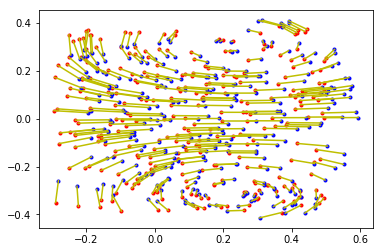

In [6]:
n = 300
plt.plot(test[0][:n,0], test[0][:n,1], 'r.');
plt.plot(test[1][:n,0], test[1][:n,1], 'b.');
for k in range(n):
    st = [test[0][k,0], test[1][k,0]]
    en = [test[0][k,1], test[1][k,1]]
    plt.plot(st, en, 'y')

In [38]:
Weights = [np.array([[ 0.63827171,  1.94878605],
        [-1.54809306, -1.08798682],
        [ 0.41531103,  0.40218358],
        [ 1.9545372 ,  0.84283361]]),
 np.array([[-0.142614  , -0.50655311,  0.44099561,  1.17943999],
        [ 1.43606398, -0.29175979,  0.3383928 , -0.4229459 ]])]
Biases = [np.array([ 0.72180323, -0.71274565]),
 np.array([-0.04621402, -0.40947562, -0.06824616,  0.54733387]),
 np.array([-0.58947249, -0.48776308])]

## Feed-Forward Network

### Create the Neural Network

In [627]:
import network as Network
net = Network.Network([2, 4, 2], type='regression')

In [628]:
net.W = deepcopy(Weights)
net.b = deepcopy(Biases)

### Train the Network

In [294]:
progress = net.SGD(train, epochs=400, lrate=0.1, batch_size=10)

A Jupyter Widget

In [516]:
net.FeedForward(train1[0][0])
net.BackProp_no_increment(train1[1][0])

In [640]:
net.FeedForward(np.array(x[1][1]))
net.BackProp_no_increment(train1[1][0])

In [641]:
print(train1[0][0])
print(net.h[0])
print(net.h[1])
print(net.h[-1])

[-0.15672223 -0.22464579]
[0.43314663 0.14592792]
[0.62589205 0.22464588 0.5424809  0.82008567]
[0.413945   0.18223507]


### Test the Network

In [370]:
y = []
for x,t in zip(test[0], test[1]):
    y.append(net.FeedForward(x))

y = np.array(y)

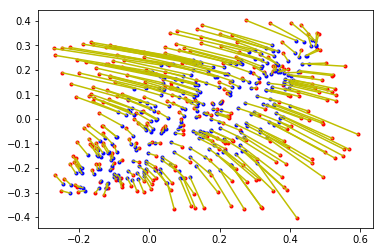

In [371]:
n = 300
plt.plot(test[1][:n,0], test[1][:n,1], 'r.');
plt.plot(y[:n,0], y[:n,1], 'b.');
for k in range(n):
    st = [test[1][k,0], y[k,0]]
    en = [test[1][k,1], y[k,1]]
    plt.plot(st, en, 'y')

## PE Network

In [7]:
# Preliminaries
import torch
dtype = torch.float
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

importlib.reload(NN)
importlib.reload(Layer);

### Create the Neural Network

In [37]:
pe_net = NN.NeuralNetwork()
pe_net.AddLayer(Layer.InputPELayer(n=2))
pe_net.ConnectNextLayer(Layer.PELayer(n=2))
#pe_net.ConnectNextLayer(Layer.PELayer(n=4))
pe_net.ConnectNextLayer(Layer.TopPELayer(n=2))
sym = True
pe_net.Connect(0, 1, act='identity', symmetric=sym)
#pe_net.Connect(1, 2, act='logistic', symmetric=sym)
pe_net.Connect(1, 2, act='identity', symmetric=sym)
#pe_net.connections[0].MakeIdentity()
#pe_net.connections[0].Nonlearning()
pe_net.SetTau(0.08)
pe_net.learn = True
pe_net.layers[1].Probe(False)

identity
identity


In [54]:
# Construct a PE network using the same weight matrices.
# But construct it upside-down, so that it projects top
# to bottom.
pe_net.connections[2].W = torch.tensor(deepcopy(Weights[0])).float()
pe_net.connections[2].M = torch.tensor(deepcopy(Weights[0].transpose())).float()

pe_net.connections[1].W = torch.tensor(deepcopy(Weights[1])).float()
pe_net.connections[1].M = torch.tensor(deepcopy(Weights[1].transpose())).float()

pe_net.layers[2].b = torch.tensor(deepcopy(Biases[1])).float()
pe_net.layers[1].b = torch.tensor(deepcopy(Biases[2])).float()

In [60]:
pe_net.connections[2].W

tensor([[ 0.6383,  1.9488],
        [-1.5481, -1.0880],
        [ 0.4153,  0.4022],
        [ 1.9545,  0.8428]])

### Pre-training performance

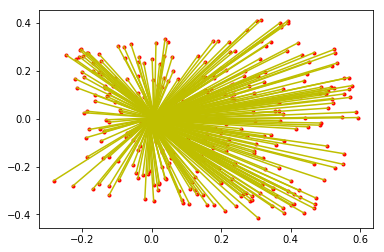

In [38]:
pe_net.SetTau(0.08)
pe_net.BackprojectExpectation(testtf[0])
yy = pe_net.Generate(4., testtf[0], dt=0.01)
#pe_net.Infer(1., testtf[1], testtf[0], dt=0.01)
#yy = pe_net.layers[0].v
y_true = testtf[1]
y = yy
#y = np.array([np.array(pe_net.layers[-1].sigma(k)) for k in yy])

n = 300
plt.plot(np.array(y_true[:n,0]), np.array(y_true[:n,1]), 'r.')
plt.plot(np.array(y[:n,0]), np.array(y[:n,1]), 'b.')
for k in range(n):
    st = [y_true[k,0], y[k,0]]
    en = [y_true[k,1], y[k,1]]
    plt.plot(st, en, 'y')

### Train the network

In [16]:
len(traintf[0])

500

In [39]:
pe_net.Reset()
pe_net.learning_tau = 0.8
pe_net.SetWeightDecay(0.00) # 0.05 too high
pe_net.SetvDecay(0.00)
pe_net.Learn(traintf[0], traintf[1], T=3., dt=0.002, epochs=10, batch_size=50)

In [70]:
train_shuffle = list(zip(traintf[0],traintf[1]))
batch_size = 4
pe_net.learning_tau = 10. #torch.tensor(batch_size).float().to(device) * 5.
epochs = 200
fp = FloatProgress(min=0,max=epochs*len(train_shuffle))
display(fp)
pe_net.layers[1].Probe(False)
pe_net.learning_blackout = 1.
T = 3.
start_time = time.time()
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    unzip = list(zip(*train_shuffle))
    batches = NN.MakeBatches(unzip[0], unzip[1], batch_size)
    for x in batches:
        #pe_net.Reset()
        pe_net.BackprojectExpectation(x[0])
        pe_net.Infer(T, x[1], x[0], learning=True)
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Allocating
Total time: 1830.1883370876312


In [72]:
pe_net.Save('warp_2x4x2.npy')

### Run the network

In [15]:
pe_net = NN.NeuralNetwork()
pe_net.Load('warp_2x4x2.npy')

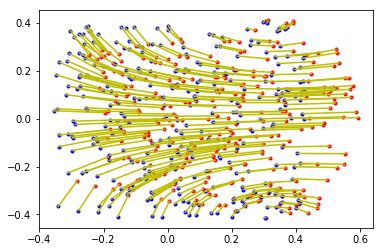

In [36]:
pe_net.Reset()
pe_net.SetTau(0.08)
pe_net.SetvDecay(0.00)
y = pe_net.Generate(4., testtf[0], dt=0.01)
y_true = testtf[1]
#y = np.array([np.array(pe_net.layers[-1].sigma(k)) for k in yy])

n = 300
plt.plot(np.array(y_true[:n,0]), np.array(y_true[:n,1]), 'r.')
plt.plot(np.array(y[:n,0]), np.array(y[:n,1]), 'b.')
for k in range(n):
    st = [y_true[k,0], y[k,0]]
    en = [y_true[k,1], y[k,1]]
    plt.plot(st, en, 'y')

In [64]:
pe_net.BackprojectExpectation(train1[0][0])
pe_net.layers[1].Probe(True)
pe_net.Infer(2., train1[1][0], train1[0][0])

Allocating


In [65]:
print(train1[0][0])
print(pe_net.layers[-1].v)
print(Layer.identity(pe_net.layers[1].v))
print(pe_net.layers[0].v)

[0.14912566 0.35972994]
tensor([ 0.1491,  0.3597])
tensor([ 0.1244,  0.3431])
tensor([ 0.1244,  0.3431])


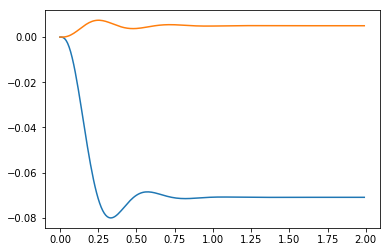

In [66]:
plt.plot(pe_net.t_history, pe_net.layers[1].e_history);

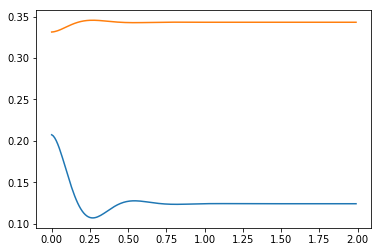

In [67]:
plt.plot(pe_net.t_history, pe_net.layers[1].v_history);